Access-Control Queuing Task
---
This is a decision task involving access control to a set of 10 servers. Customers of four different priorities arrive at a single queue. If given access to a server, the customers pay a reward of `1, 2, 4, or 8` to the server, depending on their priority, with higher priority customers paying more. In each time step, the customer at the head of the queue is either accepted (assigned to one of the servers) or rejected (removed from the queue, with a reward of zero). In either case, on the next time step the next customer in the queue is considered. The queue never empties, and the priorities of the customers in the queue are equally randomly distributed. Of course a customer cannot be served if there is no free server; the customer is always rejected in this case. Each busy server becomes free with probability `p = 0.06` on each time step.

The task is to decide on each step whether to accept or reject the next customer, on the basis of his priority and the number of free servers, so as `to maximize long-term reward without discounting`.

- State(num_servers, priority)
- Action(1, 0)
- Reward(1, 2, 4, 8)
---
<img src="differential_sarsa.png" width="600" style="float:left">

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from TileCoding import *

In [6]:
ACTIONS = [0, 1]

In [60]:
class ValueFunction:

    def __init__(self, alpha=0.01, numOfTilings=8, maxSize=2048):
        self.maxSize = maxSize
        self.numOfTilings = numOfTilings

        # divide step size equally to each tiling
        self.alpha = alpha / numOfTilings  # learning rate for each tile

        self.hashTable = IHT(maxSize)

        # weight for each tile
        self.weights = np.zeros(maxSize)

        # position and velocity needs scaling to satisfy the tile software
        self.serverScale = self.numOfTilings / 10.0  # 10 servers
        self.priorityScale = self.numOfTilings / 3.0  # 4 kinds of priorities

    # get indices of active tiles for given state and action
    def getActiveTiles(self, n_server, priority, action):
        activeTiles = tiles(self.hashTable, self.numOfTilings,
                            [self.serverScale * n_server, self.priorityScale * priority],
                            [action])
#         print("active tiles for {}-{}-{}: {}".format(n_server, priority, action, activeTiles))
        return activeTiles

    # estimate the value of given state and action
    def value(self, state, action):
        n_server, priority = state
        activeTiles = self.getActiveTiles(n_server, priority, action)
        return np.sum(self.weights[activeTiles])

    # learn with given state, action and target
    def update(self, state, action, delta):
        n_server, priority = state
        activeTiles = self.getActiveTiles(n_server, priority, action)
        
        delta *= self.alpha
        for activeTile in activeTiles:
            self.weights[activeTile] += delta
            
    def stateValue(self, state):
        if state[0] == 0:
            # no server available
            return self.value(state, 0)
        values = [self.value(state, a) for a in ACTIONS]
        return max(values)

In [58]:
class ServerAcess:
    def __init__(self, exp_rate=0.3, lr=0.1, beta=0.01):
        self.n_server = 10
        self.free_prob = 0.06
        self.priorities = range(4)
        self.actions = ACTIONS  # 0: reject; 1: accept
        self.state = (0, 0)  # (num_servers, priority)
        
        self.exp_rate = exp_rate
        self.lr = lr
        self.beta = beta
#         self.alpha = alpha
        
    def numFreeServers(self):
        n = 0
        n_free_server = self.state[0]
        n_busy_server = self.n_server - n_free_server
        for _ in range(n_busy_server):
            if np.random.uniform(0, 1) <= 0.06:
                n += 1
        n_free_server += n
        self.state = (n_free_server, self.state[1])
        return n_free_server
    
    def chooseAction(self, valueFunc):
        n_free_server = self.numFreeServers()
        if n_free_server == 0:
            return 0
        if np.random.uniform(0, 1) <= self.exp_rate:
            action = np.random.choice(self.actions)
        else:
            values = {}
            for a in self.actions:
                v = valueFunc.value(self.state, a)
                values[a] = v
            action = np.random.choice([k for k, v in values.items() if v == max(values.values())])
        return action
    
    def nxtState(self, action):
        if action == 1:
            n_free_server = self.state[0] - 1
        else:
            n_free_server = self.state[0]
        priority = np.random.choice(self.priorities)
        self.state = (n_free_server, priority)
        return self.state
    
    def giveReward(self, action):
        # recieve a reward by taking the action
        if action == 1:
            priority = self.state[1]
            return np.power(2, priority)
        return 0
    
    def run(self, valueFunc, steps=1000, inner_steps=100, debug=False):
        # updating average reward estimation along the way
        avg_reward = 0
        self.state = (10, np.random.choice(self.priorities))
        cur_state = self.state
        cur_action = self.chooseAction(valueFunc)  # n free server is also updated
        
        total_reward = 0
        for i in range(1, steps+1):
            reward = self.giveReward(cur_action)
            new_state = self.nxtState(cur_action)
            new_action = self.chooseAction(valueFunc)
            
            total_reward += reward
            if debug:
                print("state {} action {} reward {}".format(cur_state, cur_action, reward))
            if i % inner_steps == 0:
                print("step {} -> avg reward {} total reward {}".format(i, avg_reward, total_reward))
                total_reward = 0
            
            delta = reward - avg_reward + valueFunc.value(new_state, new_action) - valueFunc.value(cur_state, cur_action)
            avg_reward += self.beta*delta
            valueFunc.update(cur_state, cur_action, delta)
            
            cur_state = new_state
            cur_action = new_action

In [59]:
sa = ServerAcess(exp_rate=0.1)
vf = ValueFunction()
sa.run(vf, steps=50000, inner_steps=5000, debug=False)

step 5000 -> avg reward 2.5898638607383124 total reward 11564
step 10000 -> avg reward 1.9977852171103436 total reward 11136
step 15000 -> avg reward 2.0811726628648675 total reward 11844
step 20000 -> avg reward 2.7027010976915133 total reward 11292
step 25000 -> avg reward 1.9270934931878343 total reward 11388
step 30000 -> avg reward 2.4730018256264508 total reward 11507
step 35000 -> avg reward 2.4343651511460105 total reward 11734
step 40000 -> avg reward 2.082349301008451 total reward 10928
step 45000 -> avg reward 1.9432234467044867 total reward 10750
step 50000 -> avg reward 2.462456921306841 total reward 11731


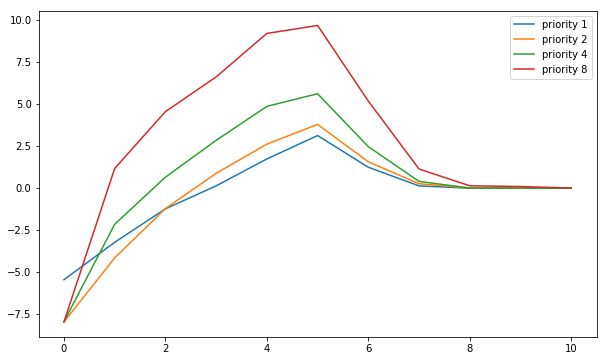

In [46]:
plt.figure(figsize=[10, 6])

for prioriy in range(4):
    n_servers = []
    values = []
    for n_server in range(11):
        value = vf.stateValue((n_server, prioriy))
        n_servers.append(n_server)
        values.append(value)
    plt.plot(n_servers, values, label="priority {}".format(np.power(2, prioriy)))
plt.legend()